# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**План**

1. Подготовка
    * Загрузка
    * Переработка
    * Анализ текста
    * Очистка текста
    * Лемматизация
3. Обучение
    * Контрольная выборка
    * Подготовка валидации
    * SearchCV
        * Dummy
        * LogisticRegression
        * RandomForestClassifier
        * LGBMClassifier
4. Контроль
    * F1
    * PR
    * AUC-ROC 
    * Dummy 
5. Заключение

**Содержание**<a id='toc0_'></a>    
1. [Подготовка](#toc1_)    
1.1. [Загрузка](#toc1_1_)    
1.2. [Переработка](#toc1_2_)    
1.3. [Анализ текста](#toc1_3_)    
1.4. [Очистка текста](#toc1_4_)    
1.5. [Лемматизация](#toc1_5_)    
2. [Обучение](#toc2_)    
2.1. [Контрольная выборка](#toc2_1_)    
2.2. [TF-IDF](#toc2_2_)    
2.3. [Logistic Regression](#toc2_3_)    
2.4. [Random Forest](#toc2_4_)    
2.5. [LGBM Classifier](#toc2_5_)    
3. [Тестирование](#toc3_)    
3.1. [Dummy](#toc3_1_)    
4. [Выводы](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*Служебные Функции*

In [1]:
import os
import pandas as pd
import re
import contractions 
import nltk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter



from nltk.corpus import stopwords 
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True);

In [2]:
CROSS_VAL = 3
BERT_FOUND = False
RANDOM = 0
tqdm.pandas()
pd.set_option('max_rows', 60) # Использую `df` для отображения, на случай, если по умолчанию выставлено большое значение.

## 1. <a id='toc1_'></a>[Подготовка](#toc0_)


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### 1.1. <a id='toc1_1_'></a>[Загрузка](#toc0_)

In [3]:
path_local = 'datasets/'
path_platform = '/datasets/'
path_extra = ''

df_list = [
    'toxic_comments.csv',
]

if os.path.exists(path_local) and all(list(map(os.path.exists, map(lambda x: path_local + x, df_list)))):
    df_dir = path_local
    print("Файлы найдены.")
elif os.path.exists(path_platform) and all(list(map(os.path.exists, map(lambda x: path_platform + x, df_list)))):
    df_dir = path_platform
    print("Файлы найдены.")
elif os.path.exists(path_extra) and all(list(map(os.path.exists, map(lambda x: path_extra + x, df_list)))):
    df_dir = path_extra
    print("Файлы найдены.")
elif all(list(map(os.path.exists, df_list))):
    df_dir = ''
    print("Файлы найдены.")
else:
    print("Директория не найдена. Файлы не найдены в текущей.")  

df = pd.read_csv(os.path.join(df_dir, 'toxic_comments.csv'), usecols=['text', 'toxic'])

Файлы найдены.


In [4]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
pd.concat([df.toxic.value_counts(), df.toxic.value_counts(normalize=True)], axis=1, keys=['toxic', 'percentage'])

,toxic,percentage
0,143106,0.898388
1,16186,0.101612


**Выводы**

В данных представлены комментарии на английском языке, бинарная оценка их токсичности и старый индекс, его отбросим. Всего около 160 тысяч записей. Классы не сбалансированы, 10% токсичных.  

### 1.2. <a id='toc1_2_'></a>[Переработка](#toc0_)

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [9]:
df.dtypes

text     object
toxic     int64
dtype: object

In [10]:
df.toxic = df.toxic.astype(bool)
df.dtypes

text     object
toxic      bool
dtype: object

**Выводы**

Пропусков нет. Дубликатов нет. Типы данных, объект и целое, приведены к объекту и булевым значениям, в соответствии данным.

### 1.3. <a id='toc1_3_'></a>[Анализ текста](#toc0_)


In [11]:
df.text.str.len().max()

5000

In [12]:
pd.concat([df.text.str.len().value_counts(bins=range(0, 5001, 500)).sort_index(),
           df.text.str.len().value_counts(bins=range(0, 5001, 500), normalize=True).sort_index()],
           axis=1, keys=['length', 'percentage'])



,length,percentage
"(-0.001, 500.0]",125441,0.787491
"(500.0, 1000.0]",20527,0.128864
"(1000.0, 1500.0]",6672,0.041885
"(1500.0, 2000.0]",2621,0.016454
"(2000.0, 2500.0]",1210,0.007596
"(2500.0, 3000.0]",731,0.004589
"(3000.0, 3500.0]",569,0.003572
"(3500.0, 4000.0]",486,0.003051
"(4000.0, 4500.0]",397,0.002492
"(4500.0, 5000.0]",638,0.004005


In [13]:
pd.concat([df.text.str.len().value_counts(bins=[0, 500, 5000]).sort_index(),
           df.text.str.len().value_counts(bins=[0, 500, 5000], normalize=True).sort_index()],
           axis=1, keys=['length', 'percentage'])



,length,percentage
"(-0.001, 500.0]",125441,0.787491
"(500.0, 5000.0]",33851,0.212509


In [14]:
df.text.str.len().idxmax()

4167

In [15]:
df.text[4167]

'ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARRES

In [16]:
df_text_lc = df.text.astype('U')
df_text_lc[df_text_lc.str.casefold() != df_text_lc.str.lower()]

126       Ahh, Hello Witzeman \n\n203.92.84.161  \nSymbo...
228       http://www.users.bigpond.com/MONTDALE/page8.ht...
733       "\n{| width=""100%"" style=""background:transp...
2622                        "::Thanks.   (Μελ Ετητης) \n\n"
3219      "\n\n Thank you for pointing out that ""Anne o...
                                ...                        
156841    "Hi again MjolnirPants. Sorry again, but  keep...
157002    "\n\n Großhauptsturmführer \n\nHi Arm, I've re...
157052    "\nThere may be a point in there about categor...
157783    "== Merge proposal ==\n\nI would support a mer...
158610    ]]\n\n (1908), left to right: Fritz Klimsch Au...
Name: text, Length: 145, dtype: object

In [17]:
df_text_lc = df_text_lc.str.casefold()
df_text_lc

0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore\ni can't make any real suggestions on ...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159287    ":::::and for the second time of asking, when ...
159288    you should be ashamed of yourself \n\nthat is ...
159289    spitzer \n\numm, theres no actual article for ...
159290    and it looks like it was actually you who put ...
159291    "\nand ... i really don't think you understand...
Name: text, Length: 159292, dtype: object

**Выводы**

Комментарии содержат довольно длинные строки, 80% короче 500, но также есть строки длинной до 5000. Учитывая большой объём данных и то, что мы анализируем на предмет токсичности, уместно привести данные к нижнему регистру. 145 строк содержат нестандартные символы, воспользуемся `.casefold()` для приведения к нижнему регистру. Также приведём текст к стандарту Unicode.

### 1.4. <a id='toc1_4_'></a>[Очистка текста](#toc0_)

In [18]:
df_text_cleansed = df_text_lc.map(lambda x: re.sub(r'[^a-z\' ]', " ",  x))
df_text_cleansed

0         explanation why the edits made under my userna...
1         d'aww  he matches this background colour i'm s...
2         hey man  i'm really not trying to edit war  it...
3           more i can't make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159287          and for the second time of asking  when ...
159288    you should be ashamed of yourself   that is a ...
159289    spitzer   umm  theres no actual article for pr...
159290    and it looks like it was actually you who put ...
159291      and     i really don't think you understand ...
Name: text, Length: 159292, dtype: object

In [19]:
df_text_cleansed = df_text_cleansed.map(lambda x: contractions.fix(x))
df_text_cleansed

0         explanation why the edits made under my userna...
1         d'aww  he matches this background colour i am ...
2         hey man  i am really not trying to edit war  i...
3           more i cannot make any real suggestions on i...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159287          and for the second time of asking  when ...
159288    you should be ashamed of yourself   that is a ...
159289    spitzer   umm  there is no actual article for ...
159290    and it looks like it was actually you who put ...
159291      and     i really do not think you understand...
Name: text, Length: 159292, dtype: object

In [20]:
stop_words = set(stopwords.words('english')) 
df_text_cleansed = df_text_cleansed.map(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_text_cleansed

0         explanation edits made username hardcore metal...
1         d'aww matches background colour seemingly stuc...
2         hey man really trying edit war guy constantly ...
3         cannot make real suggestions improvement wonde...
4                             sir hero chance remember page
                                ...                        
159287    second time asking view completely contradicts...
159288                 ashamed horrible thing put talk page
159289    spitzer umm actual article prostitution ring c...
159290    looks like actually put speedy first version d...
159291    really think understand came idea bad right aw...
Name: text, Length: 159292, dtype: object

In [21]:
df_text_cleansed[df_text_cleansed.astype(bool) != True]

2091       
2400       
3983       
4475       
6289       
         ..
148595     
151107     
152543     
153041     
158740     
Name: text, Length: 62, dtype: object

In [22]:
df_text_purged = df_text_cleansed[df_text_cleansed.astype(bool) != False]
df_text_purged

0         explanation edits made username hardcore metal...
1         d'aww matches background colour seemingly stuc...
2         hey man really trying edit war guy constantly ...
3         cannot make real suggestions improvement wonde...
4                             sir hero chance remember page
                                ...                        
159287    second time asking view completely contradicts...
159288                 ashamed horrible thing put talk page
159289    spitzer umm actual article prostitution ring c...
159290    looks like actually put speedy first version d...
159291    really think understand came idea bad right aw...
Name: text, Length: 159230, dtype: object

**Выводы**

Для упрощения дальнейшей обработки приведём тексты к строкам содержащим только слова. Для этого отбросим все символы, кроме букв английского алфавита и апострофа, после чего раскроем сокращения и отбросим "стоп слова". В результате обработки ряд строк опустел. Отбросим их.

### 1.5. <a id='toc1_5_'></a>[Лемматизация](#toc0_)

In [23]:
lemmatizer = WordNetLemmatizer()

In [24]:
def tuple_if(ser):
    a, b = ser.values
    if b:
        return (a, b)
    else:
        return (a,)

In [25]:
def lemmatize_sentence(sentence_to_lemm):
    sentence_frame = pd.DataFrame.from_records(pos_tag(sentence_to_lemm.split( )), columns=['word', 'tag'])
    sentence_frame.tag = sentence_frame.tag.map(lambda x: x[0].lower())
    sentence_frame.tag = sentence_frame.tag.where(sentence_frame.tag.isin(['a', 'r', 'n', 'v']), None)
    return ' '.join([lemmatizer.lemmatize(*word_tag) for word_tag in sentence_frame.apply(tuple_if, axis=1).to_list()])

In [26]:

df_text_lemmatized = df_text_purged.progress_apply(lemmatize_sentence)
df_text_lemmatized

100%|██████████| 159230/159230 [14:26<00:00, 183.70it/s]


0         explanation edits make username hardcore metal...
1         d'aww match background colour seemingly stuck ...
2         hey man really try edit war guy constantly rem...
3         cannot make real suggestion improvement wonder...
4                             sir hero chance remember page
                                ...                        
159287    second time ask view completely contradict cov...
159288                 ashamed horrible thing put talk page
159289    spitzer umm actual article prostitution ring c...
159290    look like actually put speedy first version de...
159291    really think understand come idea bad right aw...
Name: text, Length: 159230, dtype: object

**Выводы**

Для обучения моделей текст лемматизирован с помощью класса `WordNetLemmatizer` модуля `ntlk.stem`. Для того чтобы это сделать, строки разбиты на слова, к ним добавлены тэги с помощью функции `ntlk.pos_tag`, и определены две функции работающие вместе чтобы привести их к требуемому лемматизатором формату. После лемматизации слова объеденины обратно в строки.

## 2. <a id='toc2_'></a>[Обучение](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Контрольная выборка](#toc0_)

In [27]:
target = df.toxic[df_text_lemmatized.index]
feat_train, feat_test, targ_train, targ_test = train_test_split(df_text_lemmatized, target, random_state=RANDOM, stratify=target)

**Выводы**

Выделен целевой признак. Отложена контрольная выборка

### 2.2. <a id='toc2_2_'></a>[TF-IDF](#toc0_)

In [28]:
tfidf = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 1), max_df=.2)
tfidf.fit(feat_train)
feat_train_tfidf = tfidf.transform(feat_train)
feat_test_tfidf = tfidf.transform(feat_test)

**Выводы**

На обучающей выборке обучен `TfidfVectorizer`. В качестве гиперпараметров для него задана обработка только униграмм(поведение по умолчанию), ограничена максимальная частота в документе(корпусе) 0.2, таким образом отброшены часто встречающиеся малоинформативные лексемы, это уместно потому что представителей позитивного класса только 10%. Обе выборки трансформированы в векторы. Данные готовы к обучению моделей.

### 2.3. <a id='toc2_3_'></a>[Logistic Regression](#toc0_)

In [29]:
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=ConvergenceWarning)

In [30]:
log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM, n_jobs=4, verbose=1)

In [31]:
cross_val_score(log_reg, feat_train_tfidf, targ_train, scoring='f1', cv=CROSS_VAL, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


array([0.74056916, 0.74396029, 0.74277583])

In [32]:
lr_param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1'],
        'C': range(10, 14),
        'tol': [1e-4, 5e-5]
    },
    {
        'solver': ['lbfgs', 'liblinear', 'newton-cg'],
        'penalty': ['l2'],
        'C': range(10, 14),
        'tol': [1e-4, 5e-5] 
    }
]

lr_gscv = GridSearchCV(log_reg, lr_param_grid, scoring='f1', cv=CROSS_VAL, verbose=1)
lr_gscv.fit(feat_train_tfidf, targ_train)
lr_gscv.best_score_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7608726725875729

In [33]:
lr_gscv.best_params_

{'C': 12, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 5e-05}

**Выводы**

Логистическая регрессия значения f1 выше требуемых на кросс валидации. С помощью перебора гиперпараметров удалось их улучшить. Это не гарантирует успеха на контрольной выборке, но большой размер набора данных и случайный способ выбора контрольной выборки говорит о том, что скорее всего удовлетворяющие показатели будут и на контрольной.

Во время перебора гиперпараметров, некоторые конфигурации не жизнеспособны, т.к. целью является найти лучшую, выключим предупреждения об этом, во избежании избытка информационного шума.

### 2.4. <a id='toc2_4_'></a>[Random Forest](#toc0_)

In [34]:
rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM, n_jobs=4, verbose=1)

In [35]:
cross_val_score(rf, feat_train_tfidf, targ_train, scoring='f1', cv=CROSS_VAL, verbose=1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_job

array([0.5894902 , 0.58764715, 0.58778382])

**Выводы**

Случайный лес крайне медленно работает на кросс валидации и даёт низкие показатели f1. Скорее всего это связано с большим количеством признаков. Качество базовой модели слишком низко, чтобы оправдать перебор гиперпараметров.

### 2.5. <a id='toc2_5_'></a>[LGBM Classifier](#toc0_)

In [36]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=RANDOM, n_jobs=4, verbose=1)

In [37]:
cross_val_score(lgbm, feat_train_tfidf, targ_train, scoring='f1', cv=CROSS_VAL, verbose=1)

[LightGBM] [Info] Number of positive: 8092, number of negative: 71522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.116179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388351
[LightGBM] [Info] Number of data points in the train set: 79614, number of used features: 7498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8093, number of negative: 71522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.101941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387832
[LightGBM] [Info] Number of data points in the train set: 79615, number of used features: 7539
[LightGBM] [In

array([0.72370046, 0.73234368, 0.73174568])

In [38]:

lgbm_param_grid = {
    'max_depth': [-1, 2, 4, 8],
    'num_leaves': [31, 20, 50, 100],
    'min_child_samples': [20, 30, 50],
    'subsample_for_bin': [5, 10, 20, 200000]   
}

lgbm_rscv = RandomizedSearchCV(lgbm, lgbm_param_grid, scoring='f1', cv=CROSS_VAL, verbose=1, random_state=RANDOM)
lgbm_rscv.fit(feat_train_tfidf, targ_train)
lgbm_rscv.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 8092, number of negative: 71522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 79614, number of used features: 370
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

0.7276268551031251

**Выводы**

LBGM на кросс валидации показывает результаты несколько хуже логистической регрессии, ниже требований проекта. Качество перебором гиперпараметров значительно не улучшилось.

## 3. <a id='toc3_'></a>[Тестирование](#toc0_)

In [39]:
pred_test = lr_gscv.best_estimator_.predict(feat_test_tfidf)
proba_true_test = lr_gscv.best_estimator_.predict_proba(feat_test_tfidf)[:, 1]
print('f1', f1_score(targ_test, pred_test))

f1 0.7556255625562557


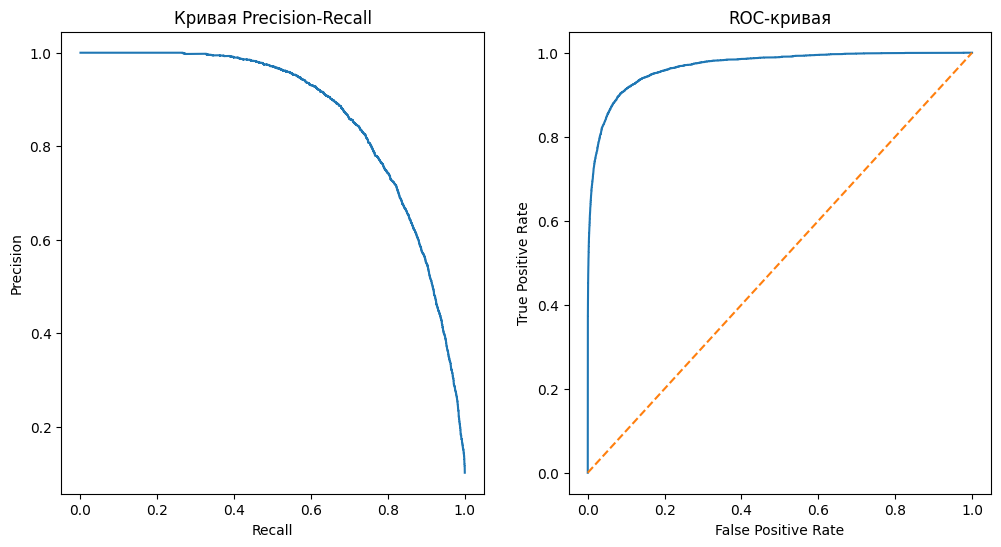

In [40]:
precision, recall, thresholds_pr =precision_recall_curve(
    targ_test.astype(int).values, lr_gscv.best_estimator_.predict_proba(feat_test_tfidf)[:, 1])

fpr, tpr, thresholds_roc = roc_curve(targ_test, proba_true_test)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')

plt.subplot(122)
plt.step(fpr, tpr, where='post')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")

plt.show() 

In [41]:
print('f1', f1_score(targ_test, pred_test))
print('Accuracy', lr_gscv.best_estimator_.score(feat_test_tfidf, targ_test))
print('roc-auc', roc_auc_score(targ_test, proba_true_test))
print('precision_score', precision_score(targ_test, pred_test))
print('recall_score', recall_score(targ_test, pred_test))

f1 0.7556255625562557
Accuracy 0.9454381028938906
roc-auc 0.9680978565577566
precision_score 0.6935150764147047
recall_score 0.8299555116164112


In [42]:
print('f1 80%', f1_score(targ_test, proba_true_test > .8))

f1 80% 0.7795409836065573


**Выводы**

Удалось достичь целевого значения f1. ROC кривая показывает, что модель категорически лучше среднего. 

 Модель имеет лучшую полноту чем точность, также можно увидеть это на PR кривой, где она падает быстрее. Возможно следует улучшить модель, оптимизировав порог предсказаний на кросс валидации, т.к. показатель f1 модели улучшается при повышении порога.

### 3.1. <a id='toc3_1_'></a>[Dummy](#toc0_)

In [43]:
dummy_uniform = DummyClassifier(strategy='uniform', random_state=RANDOM)
dummy_uniform.fit(feat_train_tfidf, targ_train)
f1_score(targ_test, dummy_uniform.predict(feat_test_tfidf))

0.1714404836356056

**Выводы**

Показатель f1 случайной модели намного хуже требуемого, что еще раз подтверждает адекватность модели.

## 4. <a id='toc4_'></a>[Выводы](#toc0_)

Обработка текстов на пример токсичности, и классификация текстов в целом, сильно зависят от выбранных способов выделения лексем(лемматизация, стемизация, размерность Nграмм) и векторизации текстовых данных. Особенностью данного набора данных является большое количество записей и очень низкое количество токсичных ("позитивных") постов. Это делает работу с ним с использованием машинного обучения довольно ёмкой, и возможно было бы более практично прибегнуть к фильтрам вульгарных слов, для того чтобы выделить наиболее явные нарушения норм общения на сайте. Низкий процент токсичных постов также приводит к тому что большинство лексем бесполезны, что учитывается при построении Tf-Idf, но также позволяет понизить вычислительную трудоёмкость работая только с редко встречающимися лексемами и отбрасывая остальные.